# EPP Screening Model - Interactive Examples

This notebook demonstrates how to use the **EPP Screening Model** package for:
- Goal seek optimization with presets
- Custom ACCU (Australian Carbon Credit Unit) volumes
- Batch sensitivity analysis
- Result visualization and export

## Prerequisites

Before running this notebook, ensure you have:
1. Installed the EPP Screening Model package (v1.1.0+)
2. Created a `config/config.toml` file with model parameters
3. Installed Jupyter dependencies: `uv sync --extra notebook`

## Setup and Imports

In [1]:
# Standard library imports
import os
import sys
import pandas as pd
import matplotlib.pyplot as plt
from pathlib import Path
from IPython.display import display

# Change to project root directory if we're in examples/
if Path.cwd().name == 'examples':
    os.chdir('..')
    print(f"Changed working directory to: {Path.cwd()}")
else:
    print(f"Working directory: {Path.cwd()}")

# Verify config file exists
config_path = Path('config/config.toml')
if config_path.exists():
    print(f"✓ Config file found: {config_path.absolute()}")
else:
    print(f"❌ Config file NOT found at: {config_path.absolute()}")
    print(f"   Please ensure config/config.toml exists in the project root")

# EPP package imports
from epp_screening_model_v3.models.goal_seek import (
    GoalSeekSolver,
    get_preset,
    list_presets_by_category
)
from epp_screening_model_v3.notebooks.epp_jupyter_helpers import (
    goal_seek_with_accu_volumes,
    batch_goal_seek_analysis
)

# Configure pandas display
pd.set_option('display.max_columns', None)
pd.set_option('display.precision', 4)

# Configure matplotlib
plt.style.use('seaborn-v0_8-darkgrid')
%matplotlib inline

# Ensure results directory exists
Path('results').mkdir(exist_ok=True)

print("✓ All imports successful")
print("✓ Results directory ready")

Changed working directory to: /Users/jim/Development/Wollemi/epp-example-external-usage
✓ Config file found: /Users/jim/Development/Wollemi/epp-example-external-usage/config/config.toml
✓ All imports successful
✓ Results directory ready


---

## Example 1: Basic Goal Seek Using Presets

The simplest way to use the EPP model is with predefined presets. Presets define:
- **Input cell**: The parameter to optimize (e.g., LVR, Property Price)
- **Target cell**: The metric to achieve (e.g., Debt Ratio, IRR)
- **Target value**: The desired outcome
- **Bounds**: Valid range for the input parameter

### 1.1 List Available Presets

In [2]:
# Get all available presets organized by category
presets = list_presets_by_category()

print("Available Goal Seek Presets:")
print("=" * 80)

for category, preset_names in presets.items():
    print(f"\n{category}:")
    for preset_name in preset_names:
        preset = get_preset(preset_name)
        print(f"  • {preset.name:30s} - {preset.description}")

Available Goal Seek Presets:

Levered Returns:
  • Levered Return 12%             - Find Property Price for 12% Levered IRR (pre-tax, incl. txn costs & cash buffer)
  • Levered Return 15%             - Find Property Price for 15% Levered IRR (pre-tax, incl. txn costs & cash buffer)
  • Levered Return 18%             - Find Property Price for 18% Levered IRR (pre-tax, incl. txn costs & cash buffer)
  • Levered Return 20%             - Find Property Price for 20% Levered IRR (pre-tax, incl. txn costs & cash buffer)

Unlevered Returns:
  • Unlevered Return 10%           - Find Property Price for 10% Unlevered IRR (incl. ag revenue & cash buffer, pre-tax)
  • Unlevered Return 12%           - Find Property Price for 12% Unlevered IRR (incl. ag revenue & cash buffer, pre-tax)
  • Unlevered Return 15%           - Find Property Price for 15% Unlevered IRR (incl. ag revenue & cash buffer, pre-tax)

Debt Ratios:
  • Debt Ratio 50%                 - Find LVR for 50% debt-to-total-capital ratio
  

### 1.2 Run Goal Seek with a Preset

Let's find the optimal LVR (Loan-to-Value Ratio) that achieves a 60% debt-to-capital ratio.

In [3]:
# Initialize solver with config file
solver = GoalSeekSolver('config/config.toml')

# Get the debt-ratio-60 preset
preset = get_preset('debt-ratio-60')

print("Preset Configuration:")
print(f"  Name: {preset.name}")
print(f"  Description: {preset.description}")
print(f"  Input Cell: {preset.input_cell}")
print(f"  Target Cell: {preset.target_cell}")
print(f"  Target Value: {preset.target_value:.2%}")
print(f"  Bounds: [{preset.min_value}, {preset.max_value}]")

# Run the goal seek
print("\nRunning solver...")
result = solver.solve(
    input_cell=preset.input_cell,
    target_cell=preset.target_cell,
    target_value=preset.target_value,
    bounds=(preset.min_value, preset.max_value),
    method=preset.suggested_method
)

print("\n" + "=" * 80)
print("Goal Seek Results")
print("=" * 80)

print(f"\n✓ Converged: {result.converged}")
print(f"  Iterations: {result.iterations}")
print(f"  Function calls: {result.function_calls}")

print(f"\nOptimal Solution:")
print(f"  LVR (Loan-to-Value): {result.solution:.4f} ({result.solution*100:.2f}%)")

print(f"\nTarget Achievement:")
print(f"  Target Debt Ratio: {result.target_value:.4f}")
print(f"  Achieved: {result.achieved_value:.4f}")
print(f"  Error: {abs(result.achieved_value - result.target_value):.2e}")

if result.unlevered_return is not None and result.levered_return is not None:
    print(f"\nFinancial Metrics:")
    print(f"  Unlevered Return (IRR): {result.unlevered_return:.4%}")
    print(f"  Levered Return (IRR): {result.levered_return:.4%}")

Preset Configuration:
  Name: Debt Ratio 60%
  Description: Find LVR for 60% debt-to-total-capital ratio
  Input Cell: Ass_Static!H197
  Target Cell: Ass_Static!H200
  Target Value: 60.00%
  Bounds: [0.3, 1.3]

Running solver...

Goal Seek Results

✓ Converged: True
  Iterations: 2
  Function calls: 3

Optimal Solution:
  LVR (Loan-to-Value): 0.9663 (96.63%)

Target Achievement:
  Target Debt Ratio: 0.6000
  Achieved: 0.6000
  Error: 0.00e+00

Financial Metrics:
  Unlevered Return (IRR): 14.3985%
  Levered Return (IRR): 17.1023%


### 1.3 Save Results

In [4]:
# Save to JSON
result.to_json('results/notebook_01_basic_goal_seek.json')
print("✓ Saved JSON: results/notebook_01_basic_goal_seek.json")

# Save optimized config
result.save_optimized_config('results/notebook_01_optimized_config.toml')
print("✓ Saved config: results/notebook_01_optimized_config.toml")

✓ Saved JSON: results/notebook_01_basic_goal_seek.json
✓ Saved config: results/notebook_01_optimized_config.toml


---

## Example 2: Goal Seek with Custom ACCU Volumes

One of the most powerful features is the ability to pass custom ACCU production volumes programmatically - no TOML files required!

ACCU volumes represent annual carbon credit generation over a 27-year period (Year 0 through Year 26).

### 2.1 Define Custom ACCU Volumes

In [5]:
# Custom ACCU production volumes for 27 years
custom_accu_volumes = [
    0.0,       # Year 0 - No production
    6750.0,    # Year 1 - Initial production
    24605.5,   # Year 2 - Ramping up
    36785.2,   # Year 3
    42933.1,   # Year 4
    44904.4,   # Year 5 - Peak production
    44481.5,   # Year 6 - Gradual decline begins
    42799.0,   # Year 7
    40511.9,   # Year 8
    37986.9,   # Year 9
    35426.2,   # Year 10
    32939.2,   # Year 11
    30581.6,   # Year 12
    28379.3,   # Year 13
    26340.3,   # Year 14
    24463.0,   # Year 15
    22740.6,   # Year 16
    21163.1,   # Year 17
    19719.8,   # Year 18
    18399.5,   # Year 19
    17191.5,   # Year 20
    16085.5,   # Year 21
    15072.1,   # Year 22
    14142.5,   # Year 23
    13288.8,   # Year 24
    0.0,       # Year 25 - End of crediting period
    0.0        # Year 26
]

print(f"ACCU Volumes Summary:")
print(f"  Years: {len(custom_accu_volumes)}")
print(f"  Total ACCUs: {sum(custom_accu_volumes):,.0f}")
print(f"  Peak production: {max(custom_accu_volumes):,.0f} (Year {custom_accu_volumes.index(max(custom_accu_volumes))})")
print(f"  Average (non-zero): {sum(custom_accu_volumes) / len([x for x in custom_accu_volumes if x > 0]):,.0f}")

ACCU Volumes Summary:
  Years: 27
  Total ACCUs: 657,690
  Peak production: 44,904 (Year 5)
  Average (non-zero): 27,404


### 2.2 Visualize ACCU Production Profile

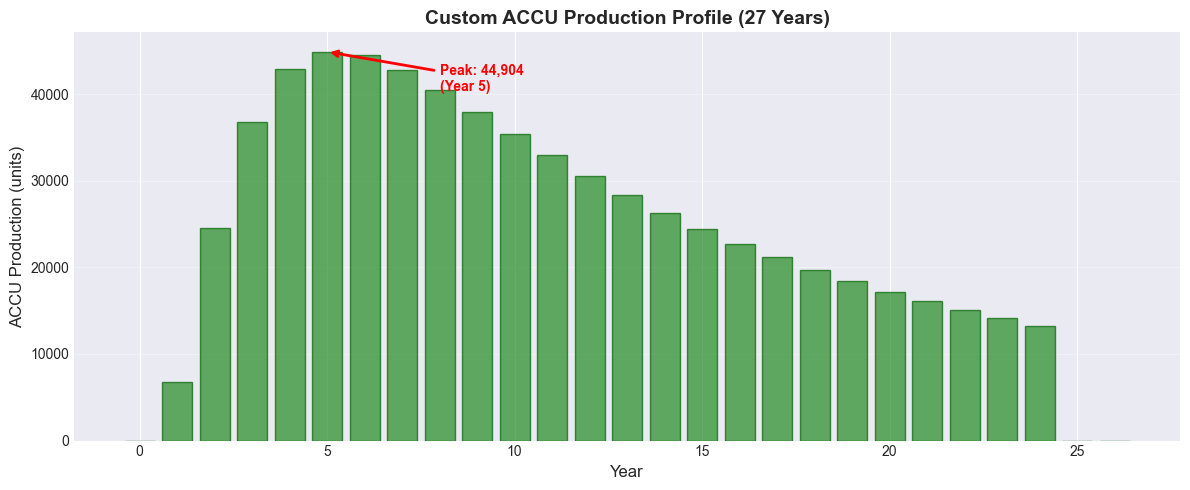

✓ Chart saved: results/notebook_accu_profile.png


In [6]:
# Create visualization of ACCU production over time
fig, ax = plt.subplots(figsize=(12, 5))

years = range(len(custom_accu_volumes))
ax.bar(years, custom_accu_volumes, color='forestgreen', alpha=0.7, edgecolor='darkgreen')
ax.set_xlabel('Year', fontsize=12)
ax.set_ylabel('ACCU Production (units)', fontsize=12)
ax.set_title('Custom ACCU Production Profile (27 Years)', fontsize=14, fontweight='bold')
ax.grid(axis='y', alpha=0.3)

# Add peak marker
peak_idx = custom_accu_volumes.index(max(custom_accu_volumes))
ax.annotate(f'Peak: {max(custom_accu_volumes):,.0f}\n(Year {peak_idx})',
            xy=(peak_idx, max(custom_accu_volumes)),
            xytext=(peak_idx + 3, max(custom_accu_volumes) * 0.9),
            arrowprops=dict(arrowstyle='->', color='red', lw=2),
            fontsize=10, fontweight='bold', color='red')

plt.tight_layout()
plt.savefig('results/notebook_accu_profile.png', dpi=150, bbox_inches='tight')
plt.show()

print("✓ Chart saved: results/notebook_accu_profile.png")

### 2.3 Run Goal Seek with Custom Volumes

In [7]:
# Run goal seek using the helper function
# This automatically handles scenario creation - no TOML files needed!
print("Running goal seek with custom ACCU volumes...\n")

result = goal_seek_with_accu_volumes(
    preset_name='debt-ratio-60',
    accu_volumes=custom_accu_volumes,
    config_path='config/config.toml',
    verbose=False
)

print("=" * 80)
print("Results")
print("=" * 80)

print(f"\n✓ Converged: {result.converged} (in {result.iterations} iterations)")

print(f"\nOptimal Solution:")
print(f"  LVR: {result.solution:.4f} ({result.solution*100:.2f}%)")

print(f"\nTarget Achievement:")
print(f"  Target: {result.target_value:.4f}")
print(f"  Achieved: {result.achieved_value:.4f}")

if result.unlevered_return and result.levered_return:
    print(f"\nFinancial Returns:")
    print(f"  Unlevered IRR: {result.unlevered_return:.4%}")
    print(f"  Levered IRR: {result.levered_return:.4%}")

print(f"\nScenario Information:")
print(f"  Scenario: {result.scenario_name}")
if result.scenario_overrides:
    print(f"  Overrides applied: {len(result.scenario_overrides)}")

Running goal seek with custom ACCU volumes...


Scenario: Custom ACCU Volumes - debt-ratio-60
Description: Programmatically created for Jupyter analysis

ACCU Volumes Override:
  Annual volumes: 27 years
  First 5 years: [0.0, 6750.0, 24605.5, 36785.2, 42933.1]
Results

✓ Converged: True (in 2 iterations)

Optimal Solution:
  LVR: 0.9663 (96.63%)

Target Achievement:
  Target: 0.6000
  Achieved: 0.6000

Financial Returns:
  Unlevered IRR: 21.1897%
  Levered IRR: 25.1552%

Scenario Information:
  Scenario: Custom ACCU Volumes - debt-ratio-60


---

## Example 3: Batch Sensitivity Analysis

Compare multiple ACCU production scenarios to understand sensitivity to different carbon credit pathways.

### 3.1 Define Multiple Scenarios

In [8]:
# Define three ACCU production scenarios
accu_scenarios = {
    'Conservative': [
        0.0, 4500.0, 16403.7, 24523.4, 28622.1, 29936.3,
        29654.3, 28532.7, 27007.9, 25324.6, 23617.5, 21959.4,
        20387.8, 18919.5, 17560.2, 16308.7, 15160.4, 14108.7,
        13146.5, 12266.4, 11461.0, 10723.7, 10048.1, 9428.3,
        8859.2, 0.0, 0.0
    ],
    'Baseline': [
        0.0, 6000.0, 21871.6, 32697.9, 38162.8, 39915.0,
        39539.1, 38043.6, 36010.6, 33766.1, 31490.0, 29279.3,
        27183.7, 25226.0, 23413.6, 21744.9, 20213.9, 18811.6,
        17528.7, 16355.2, 15281.4, 14298.3, 13397.4, 12571.1,
        11812.3, 0.0, 0.0
    ],
    'Aggressive': [
        0.0, 6750.0, 24605.5, 36785.2, 42933.1, 44904.4,
        44481.5, 42799.0, 40511.9, 37986.9, 35426.2, 32939.2,
        30581.6, 28379.3, 26340.3, 24463.0, 22740.6, 21163.1,
        19719.8, 18399.5, 17191.5, 16085.5, 15072.1, 14142.5,
        13288.8, 0.0, 0.0
    ]
}

print("ACCU Production Scenarios:")
print("=" * 80)

for name, volumes in accu_scenarios.items():
    total = sum(volumes)
    peak = max(volumes)
    peak_year = volumes.index(peak)
    print(f"  {name:15s}: Total={total:>10,.0f}, Peak={peak:>10,.0f} (Year {peak_year})")

ACCU Production Scenarios:
  Conservative   : Total=   438,460, Peak=    29,936 (Year 5)
  Baseline       : Total=   584,614, Peak=    39,915 (Year 5)
  Aggressive     : Total=   657,690, Peak=    44,904 (Year 5)


### 3.2 Visualize Scenario Comparison

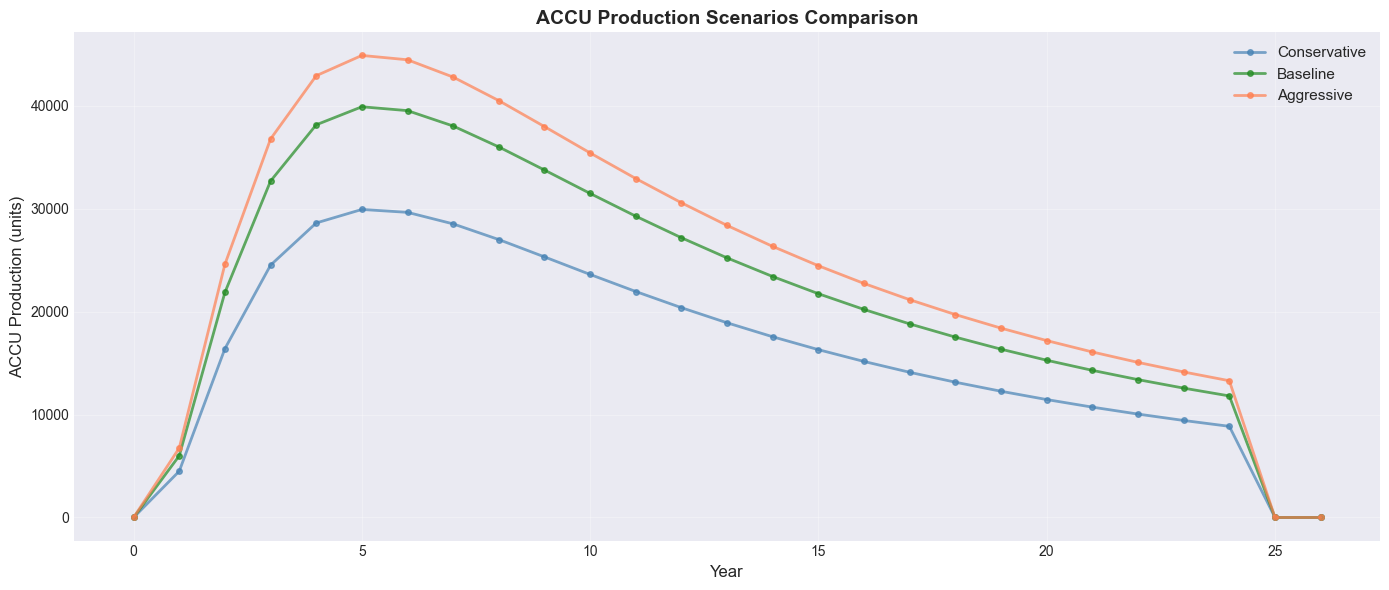

✓ Chart saved: results/notebook_scenario_comparison.png


In [9]:
# Create comparison plot
fig, ax = plt.subplots(figsize=(14, 6))

years = range(27)
colors = {'Conservative': 'steelblue', 'Baseline': 'forestgreen', 'Aggressive': 'coral'}

for name, volumes in accu_scenarios.items():
    ax.plot(years, volumes, marker='o', markersize=4, label=name, 
            color=colors[name], linewidth=2, alpha=0.7)

ax.set_xlabel('Year', fontsize=12)
ax.set_ylabel('ACCU Production (units)', fontsize=12)
ax.set_title('ACCU Production Scenarios Comparison', fontsize=14, fontweight='bold')
ax.legend(loc='upper right', fontsize=11)
ax.grid(alpha=0.3)

plt.tight_layout()
plt.savefig('results/notebook_scenario_comparison.png', dpi=150, bbox_inches='tight')
plt.show()

print("✓ Chart saved: results/notebook_scenario_comparison.png")

### 3.3 Run Batch Analysis

In [10]:
print("Running batch analysis across all scenarios...\n")

# Run batch analysis using helper function
df = batch_goal_seek_analysis(
    preset_name='debt-ratio-60',
    accu_scenarios=accu_scenarios,
    config_path='config/config.toml'
)

print("=" * 80)
print("Batch Analysis Results")
print("=" * 80)
print()
display(df)

Running batch analysis across all scenarios...


Batch Goal Seek Analysis: debt-ratio-60
Scenarios: 3

[1/3] Analyzing: Conservative
  Total ACCUs: 438,460
  Peak ACCUs: 29,936 (Year 5)

Scenario: Custom ACCU Volumes - debt-ratio-60
Description: Programmatically created for Jupyter analysis

ACCU Volumes Override:
  Annual volumes: 27 years
  First 5 years: [0.0, 4500.0, 16403.7, 24523.4, 28622.1]
  ✓ Converged in 2 iterations
  Levered Return: 17.10%

[2/3] Analyzing: Baseline
  Total ACCUs: 584,614
  Peak ACCUs: 39,915 (Year 5)

Scenario: Custom ACCU Volumes - debt-ratio-60
Description: Programmatically created for Jupyter analysis

ACCU Volumes Override:
  Annual volumes: 27 years
  First 5 years: [0.0, 6000.0, 21871.6, 32697.9, 38162.8]
  ✓ Converged in 2 iterations
  Levered Return: 22.73%

[3/3] Analyzing: Aggressive
  Total ACCUs: 657,690
  Peak ACCUs: 44,904 (Year 5)

Scenario: Custom ACCU Volumes - debt-ratio-60
Description: Programmatically created for Jupyter analysis

ACCU 

,Scenario,Total ACCUs,Peak ACCUs,Peak Year,Solution,Achieved Value,Target Value,Converged,Iterations,Unlevered Return,Levered Return
0,Conservative,438460.4,29936.3,5,0.9663,0.6,0.6,True,2,0.1440,0.1710
1,Baseline,584614.1,39915.0,5,0.9663,0.6,0.6,True,2,0.1908,0.2273
2,Aggressive,657690.5,44904.4,5,0.9663,0.6,0.6,True,2,0.2119,0.2516


### 3.4 Analysis and Insights

In [11]:
print("Key Insights:")
print("=" * 80)

if 'Levered Return' in df.columns:
    print(f"\nLevered Return Range:")
    min_idx = df['Levered Return'].idxmin()
    max_idx = df['Levered Return'].idxmax()
    print(f"  Min: {df.loc[min_idx, 'Levered Return']:.2%} ({df.loc[min_idx, 'Scenario']})")
    print(f"  Max: {df.loc[max_idx, 'Levered Return']:.2%} ({df.loc[max_idx, 'Scenario']})")
    print(f"  Spread: {(df['Levered Return'].max() - df['Levered Return'].min()):.2%}")

    print(f"\nOptimal Solution (LVR) Range:")
    min_idx = df['Solution'].idxmin()
    max_idx = df['Solution'].idxmax()
    print(f"  Min: {df.loc[min_idx, 'Solution']:.2%} ({df.loc[min_idx, 'Scenario']})")
    print(f"  Max: {df.loc[max_idx, 'Solution']:.2%} ({df.loc[max_idx, 'Scenario']})")

    print(f"\nACCU Production vs Returns:")
    correlation = df['Total ACCUs'].corr(df['Levered Return'])
    print(f"  Correlation: {correlation:.4f}")
    print(f"  Interpretation: {'Strong positive' if correlation > 0.7 else 'Moderate positive' if correlation > 0.3 else 'Weak'} relationship")

Key Insights:

Levered Return Range:
  Min: 17.10% (Conservative)
  Max: 25.16% (Aggressive)
  Spread: 8.05%

Optimal Solution (LVR) Range:
  Min: 96.63% (Conservative)
  Max: 96.63% (Conservative)

ACCU Production vs Returns:
  Correlation: 0.9994
  Interpretation: Strong positive relationship


### 3.5 Visualize Results

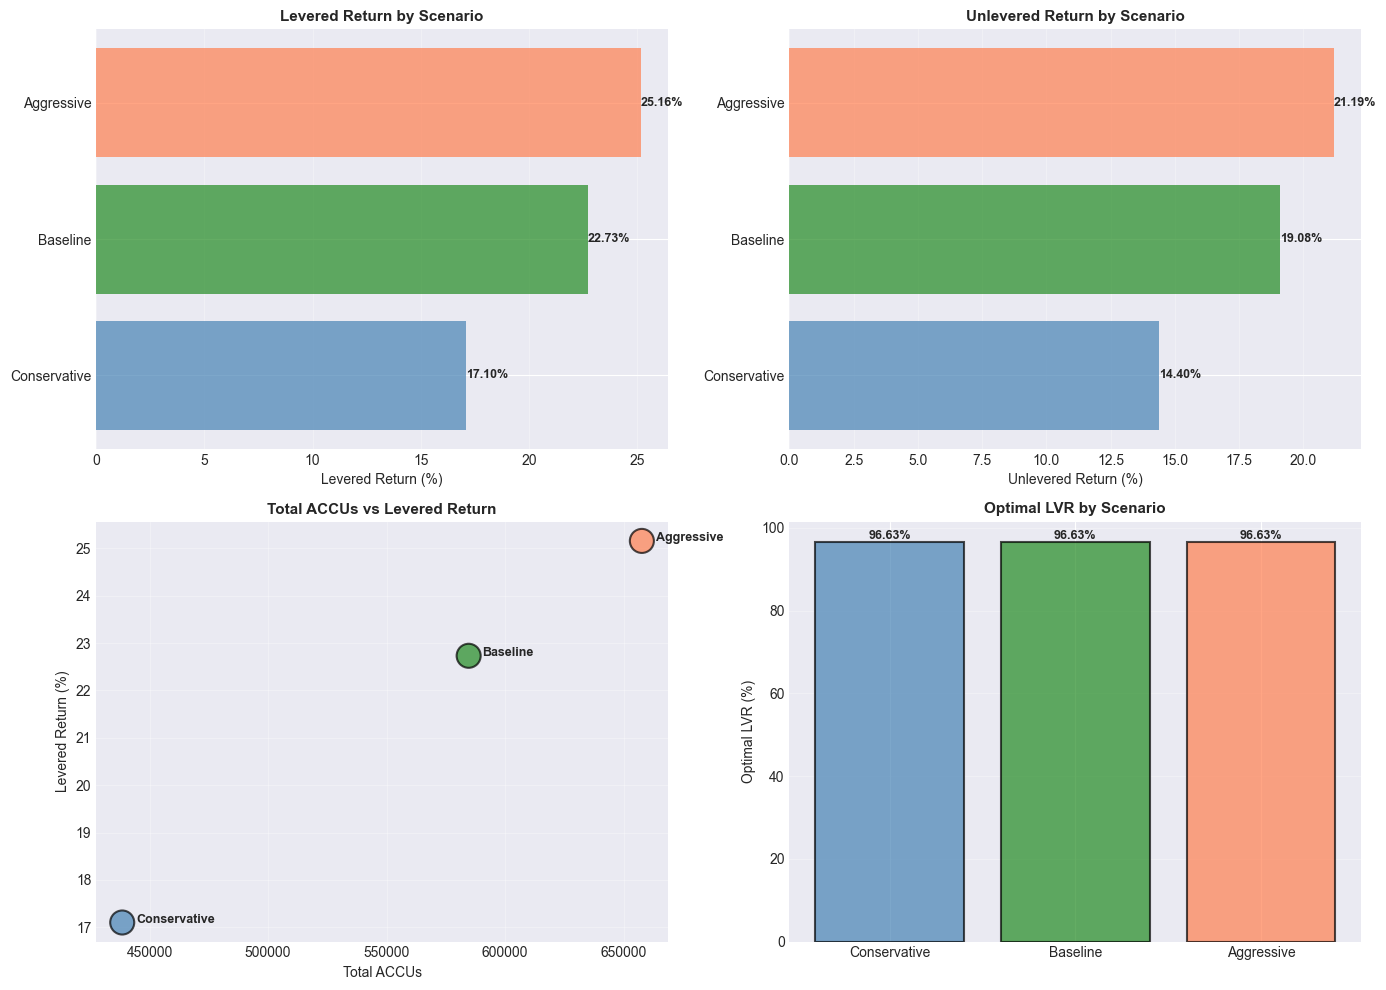

✓ Chart saved: results/notebook_batch_analysis.png


In [12]:
# Create comprehensive visualization
fig, axes = plt.subplots(2, 2, figsize=(14, 10))

# Plot 1: Levered Return by scenario
ax1 = axes[0, 0]
bars1 = ax1.barh(df['Scenario'], df['Levered Return'] * 100, 
                 color=['steelblue', 'forestgreen', 'coral'], alpha=0.7)
ax1.set_xlabel('Levered Return (%)', fontsize=10)
ax1.set_title('Levered Return by Scenario', fontsize=11, fontweight='bold')
ax1.grid(axis='x', alpha=0.3)
for i, bar in enumerate(bars1):
    width = bar.get_width()
    ax1.text(width, bar.get_y() + bar.get_height()/2, f'{width:.2f}%',
            ha='left', va='center', fontsize=9, fontweight='bold')

# Plot 2: Unlevered Return by scenario
ax2 = axes[0, 1]
bars2 = ax2.barh(df['Scenario'], df['Unlevered Return'] * 100,
                 color=['steelblue', 'forestgreen', 'coral'], alpha=0.7)
ax2.set_xlabel('Unlevered Return (%)', fontsize=10)
ax2.set_title('Unlevered Return by Scenario', fontsize=11, fontweight='bold')
ax2.grid(axis='x', alpha=0.3)
for i, bar in enumerate(bars2):
    width = bar.get_width()
    ax2.text(width, bar.get_y() + bar.get_height()/2, f'{width:.2f}%',
            ha='left', va='center', fontsize=9, fontweight='bold')

# Plot 3: Total ACCUs vs Levered Return
ax3 = axes[1, 0]
scatter_colors = [colors[s] for s in df['Scenario']]
ax3.scatter(df['Total ACCUs'], df['Levered Return'] * 100, 
           s=300, c=scatter_colors, alpha=0.7, edgecolors='black', linewidth=1.5)
for idx, row in df.iterrows():
    ax3.annotate(row['Scenario'], 
                (row['Total ACCUs'], row['Levered Return'] * 100),
                xytext=(10, 0), textcoords='offset points', 
                fontsize=9, fontweight='bold')
ax3.set_xlabel('Total ACCUs', fontsize=10)
ax3.set_ylabel('Levered Return (%)', fontsize=10)
ax3.set_title('Total ACCUs vs Levered Return', fontsize=11, fontweight='bold')
ax3.grid(alpha=0.3)

# Plot 4: Optimal LVR by scenario
ax4 = axes[1, 1]
bars4 = ax4.bar(df['Scenario'], df['Solution'] * 100,
                color=['steelblue', 'forestgreen', 'coral'], alpha=0.7, edgecolor='black', linewidth=1.5)
ax4.set_ylabel('Optimal LVR (%)', fontsize=10)
ax4.set_title('Optimal LVR by Scenario', fontsize=11, fontweight='bold')
ax4.grid(axis='y', alpha=0.3)
for i, bar in enumerate(bars4):
    height = bar.get_height()
    ax4.text(bar.get_x() + bar.get_width()/2, height,
            f'{height:.2f}%', ha='center', va='bottom', fontsize=9, fontweight='bold')

plt.tight_layout()
plt.savefig('results/notebook_batch_analysis.png', dpi=150, bbox_inches='tight')
plt.show()

print("✓ Chart saved: results/notebook_batch_analysis.png")

### 3.6 Export Results

In [13]:
# Export to CSV
df.to_csv('results/notebook_batch_analysis.csv', index=False)
print("✓ Saved CSV: results/notebook_batch_analysis.csv")

# Export to Excel with formatting
with pd.ExcelWriter('results/notebook_batch_analysis.xlsx', engine='openpyxl') as writer:
    df.to_excel(writer, index=False, sheet_name='Batch Analysis')
    
    # Get the worksheet
    worksheet = writer.sheets['Batch Analysis']
    
    # Auto-adjust column widths
    for column in worksheet.columns:
        max_length = 0
        column = [cell for cell in column]
        for cell in column:
            try:
                if len(str(cell.value)) > max_length:
                    max_length = len(str(cell.value))
            except:
                pass
        adjusted_width = (max_length + 2)
        worksheet.column_dimensions[column[0].column_letter].width = adjusted_width

print("✓ Saved Excel: results/notebook_batch_analysis.xlsx")

print("\n" + "=" * 80)
print("All examples completed successfully!")
print("=" * 80)

✓ Saved CSV: results/notebook_batch_analysis.csv
✓ Saved Excel: results/notebook_batch_analysis.xlsx

All examples completed successfully!


---

## Summary

This notebook demonstrated:

1. **Basic Goal Seek**: Using presets to optimize LVR for target debt ratios
2. **Custom ACCU Volumes**: Passing carbon credit volumes programmatically
3. **Batch Analysis**: Comparing multiple scenarios with sensitivity analysis
4. **Visualization**: Creating informative charts and graphs
5. **Export**: Saving results to JSON, CSV, and Excel formats

### Next Steps

- Explore other presets (levered-return-15, unlevered-return-12, etc.)
- Try different ACCU production profiles
- Experiment with custom parameter overrides
- Run full model calculations (see Example 4 in the Python scripts)

### Resources

- [README.md](../README.md) - Full project documentation
- [Python Examples](.) - Additional example scripts
- [EPP Package Repository](https://github.com/MullionGroup/epp_screening_model_v3) - Main package source